In [1]:
%load_ext autoreload

In [2]:
import distributed as dd
import numpy as np
import dask.array as da
import dask

from libertem.api import Context
from libertem.executor.delayed import DelayedJobExecutor
from libertem.udf.base import UDF
from libertem.udf.base import get_resources_for_backends

In [3]:
ctx = Context.make_with("dask-make-default")
# ctx = Context()
del_ctx = Context(executor=DelayedJobExecutor())

c:\users\dwebe\.conda\envs\libertem\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55269 instead
  warnings.warn(


In [4]:
class MySumUDF(UDF):
    def get_result_buffers(self):
        return {
            'intensity': self.buffer(kind='sig', dtype=self.meta.input_dtype)
        }

    def process_tile(self, tile):
        self.results.intensity[:] += np.sum(tile, axis=0)

    def merge(self, dest, src):
        dest.intensity[:] += src.intensity

In [5]:
class MySumSigUDF(UDF):
    def get_result_buffers(self):
        return {
            'intensity': self.buffer(
                kind="nav", dtype=self.meta.input_dtype
            ),
        }

    def process_tile(self, tile):
        self.results.intensity[:] += np.sum(tile, axis=tuple(range(1, len(tile.shape))))

In [31]:
ds = ctx.load('EMPAD', 'E:/LargeData/LargeData/ER-C-1/groups/data_science/data/reference/EMPAD/BiFeO3/acquisition_12.xml')
ds.set_num_cores(2)

In [7]:
res_sum = ctx.run_udf(dataset=ds, udf=MySumUDF())

In [20]:
%%timeit
res_sum = ctx.run_udf(dataset=ds, udf=MySumUDF())

1.5 s ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
res_sumsig = ctx.run_udf(dataset=ds, udf=MySumSigUDF())

2.86 s ± 865 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


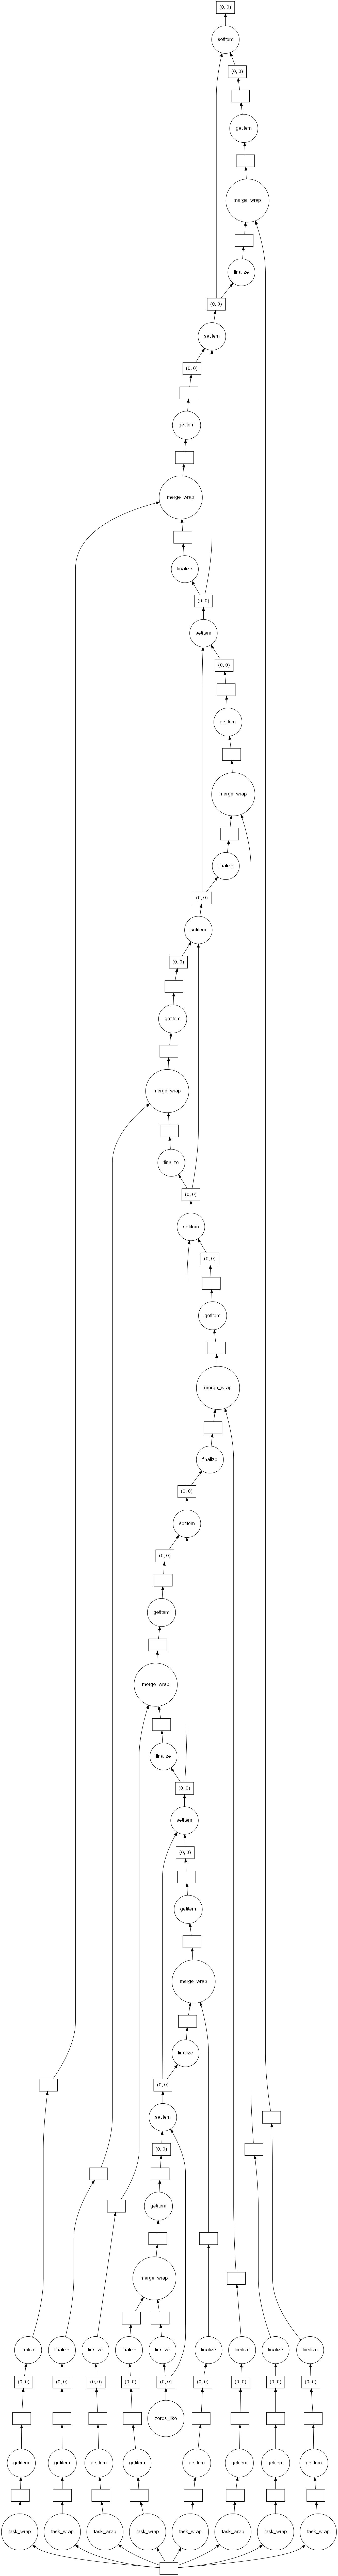

In [34]:
udf = MySumUDF()
resources = DelayedJobExecutor.get_resources(udf)
del_res_sum = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sum['intensity'].raw_data.visualize()

In [28]:
class MySumMergeUDF(MySumUDF):
    def dask_merge(self, ordered_results):
        intensity = np.stack([b.intensity for b in ordered_results.values()]).sum(axis=0)
        self.results.get_buffer('intensity').update_data(intensity)

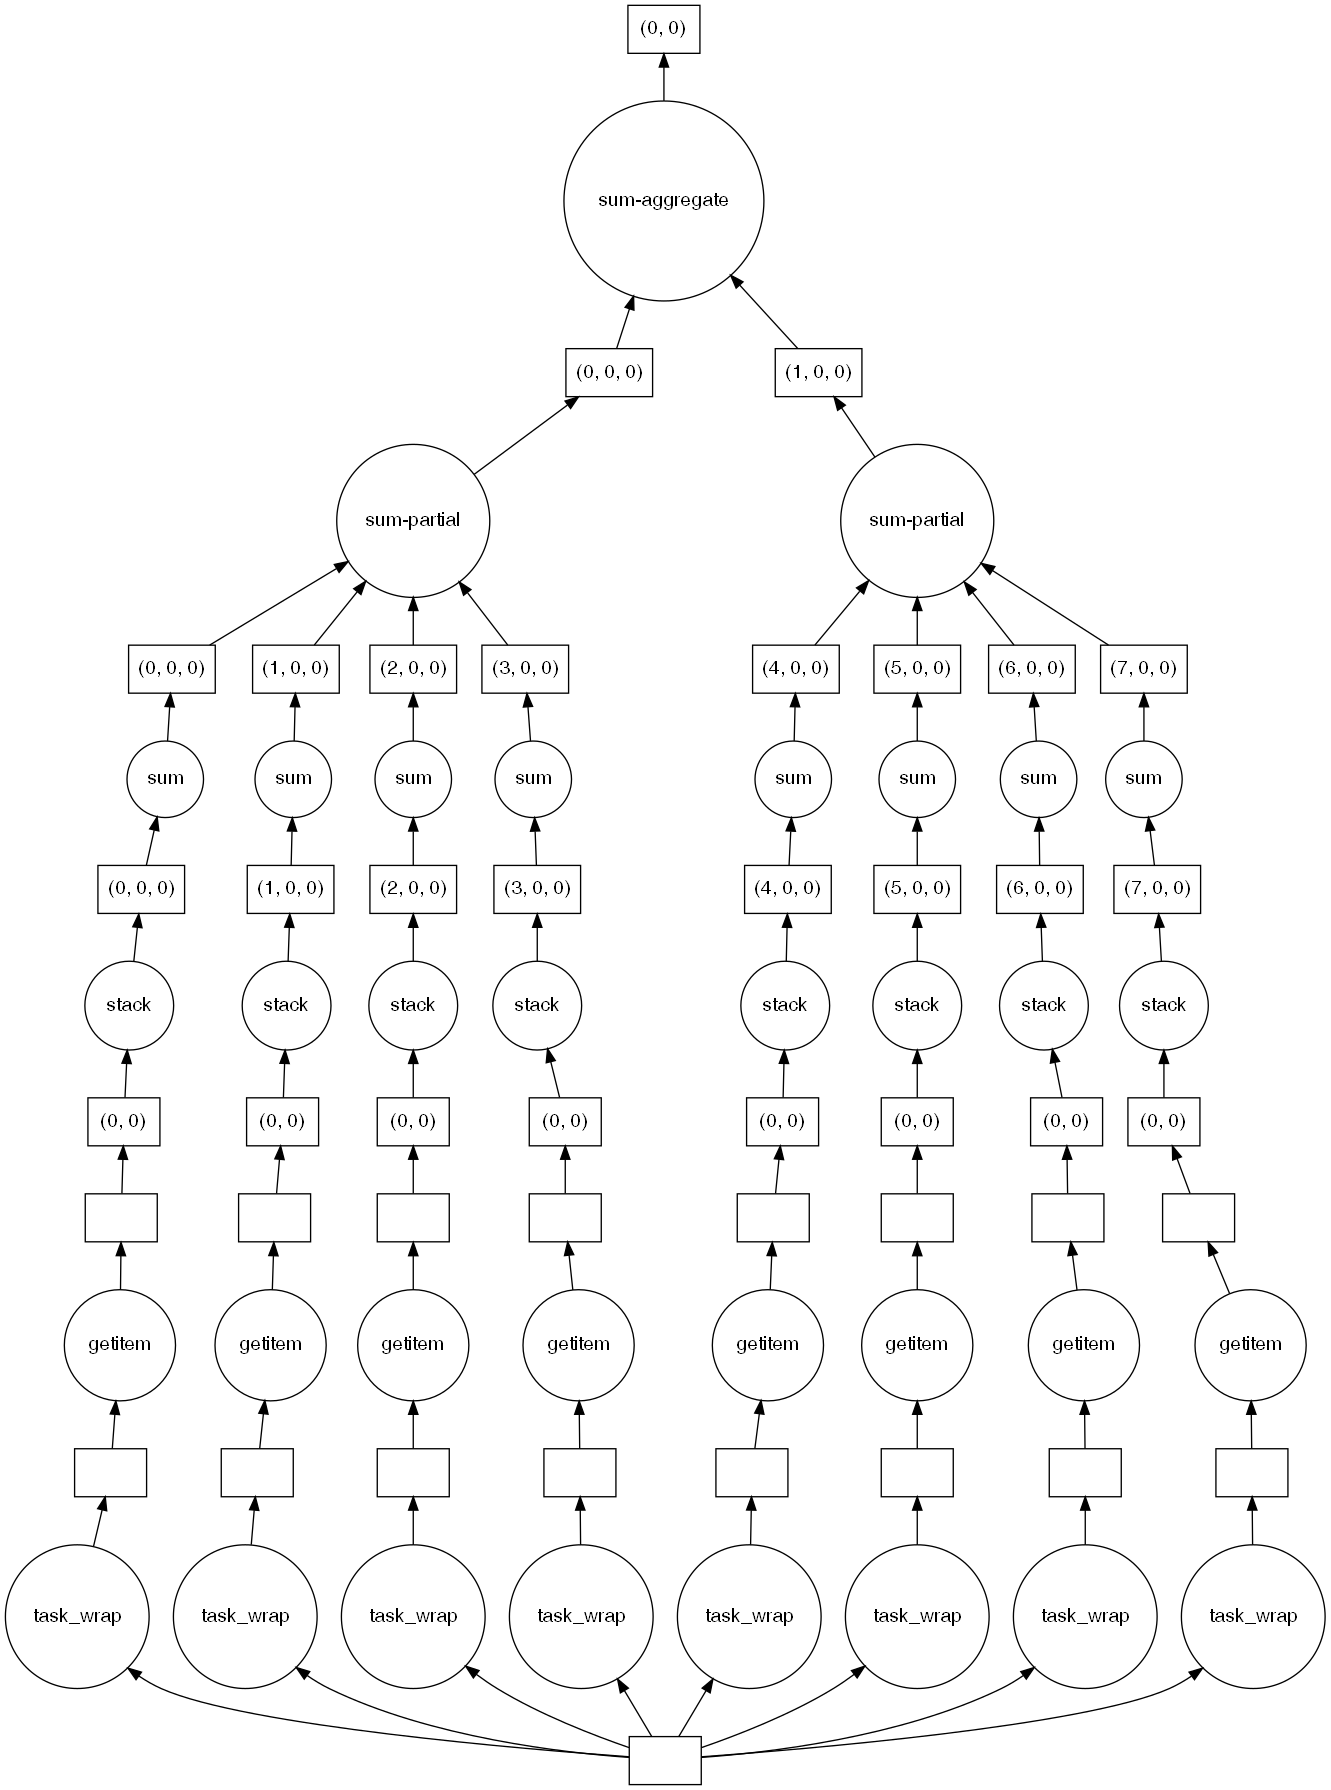

In [35]:
udf = MySumMergeUDF()
resources = DelayedJobExecutor.get_resources(udf)
del_res_sum = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sum['intensity'].raw_data.visualize()

In [13]:
%%timeit
udf = MySumSigUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.compute()

2.3 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


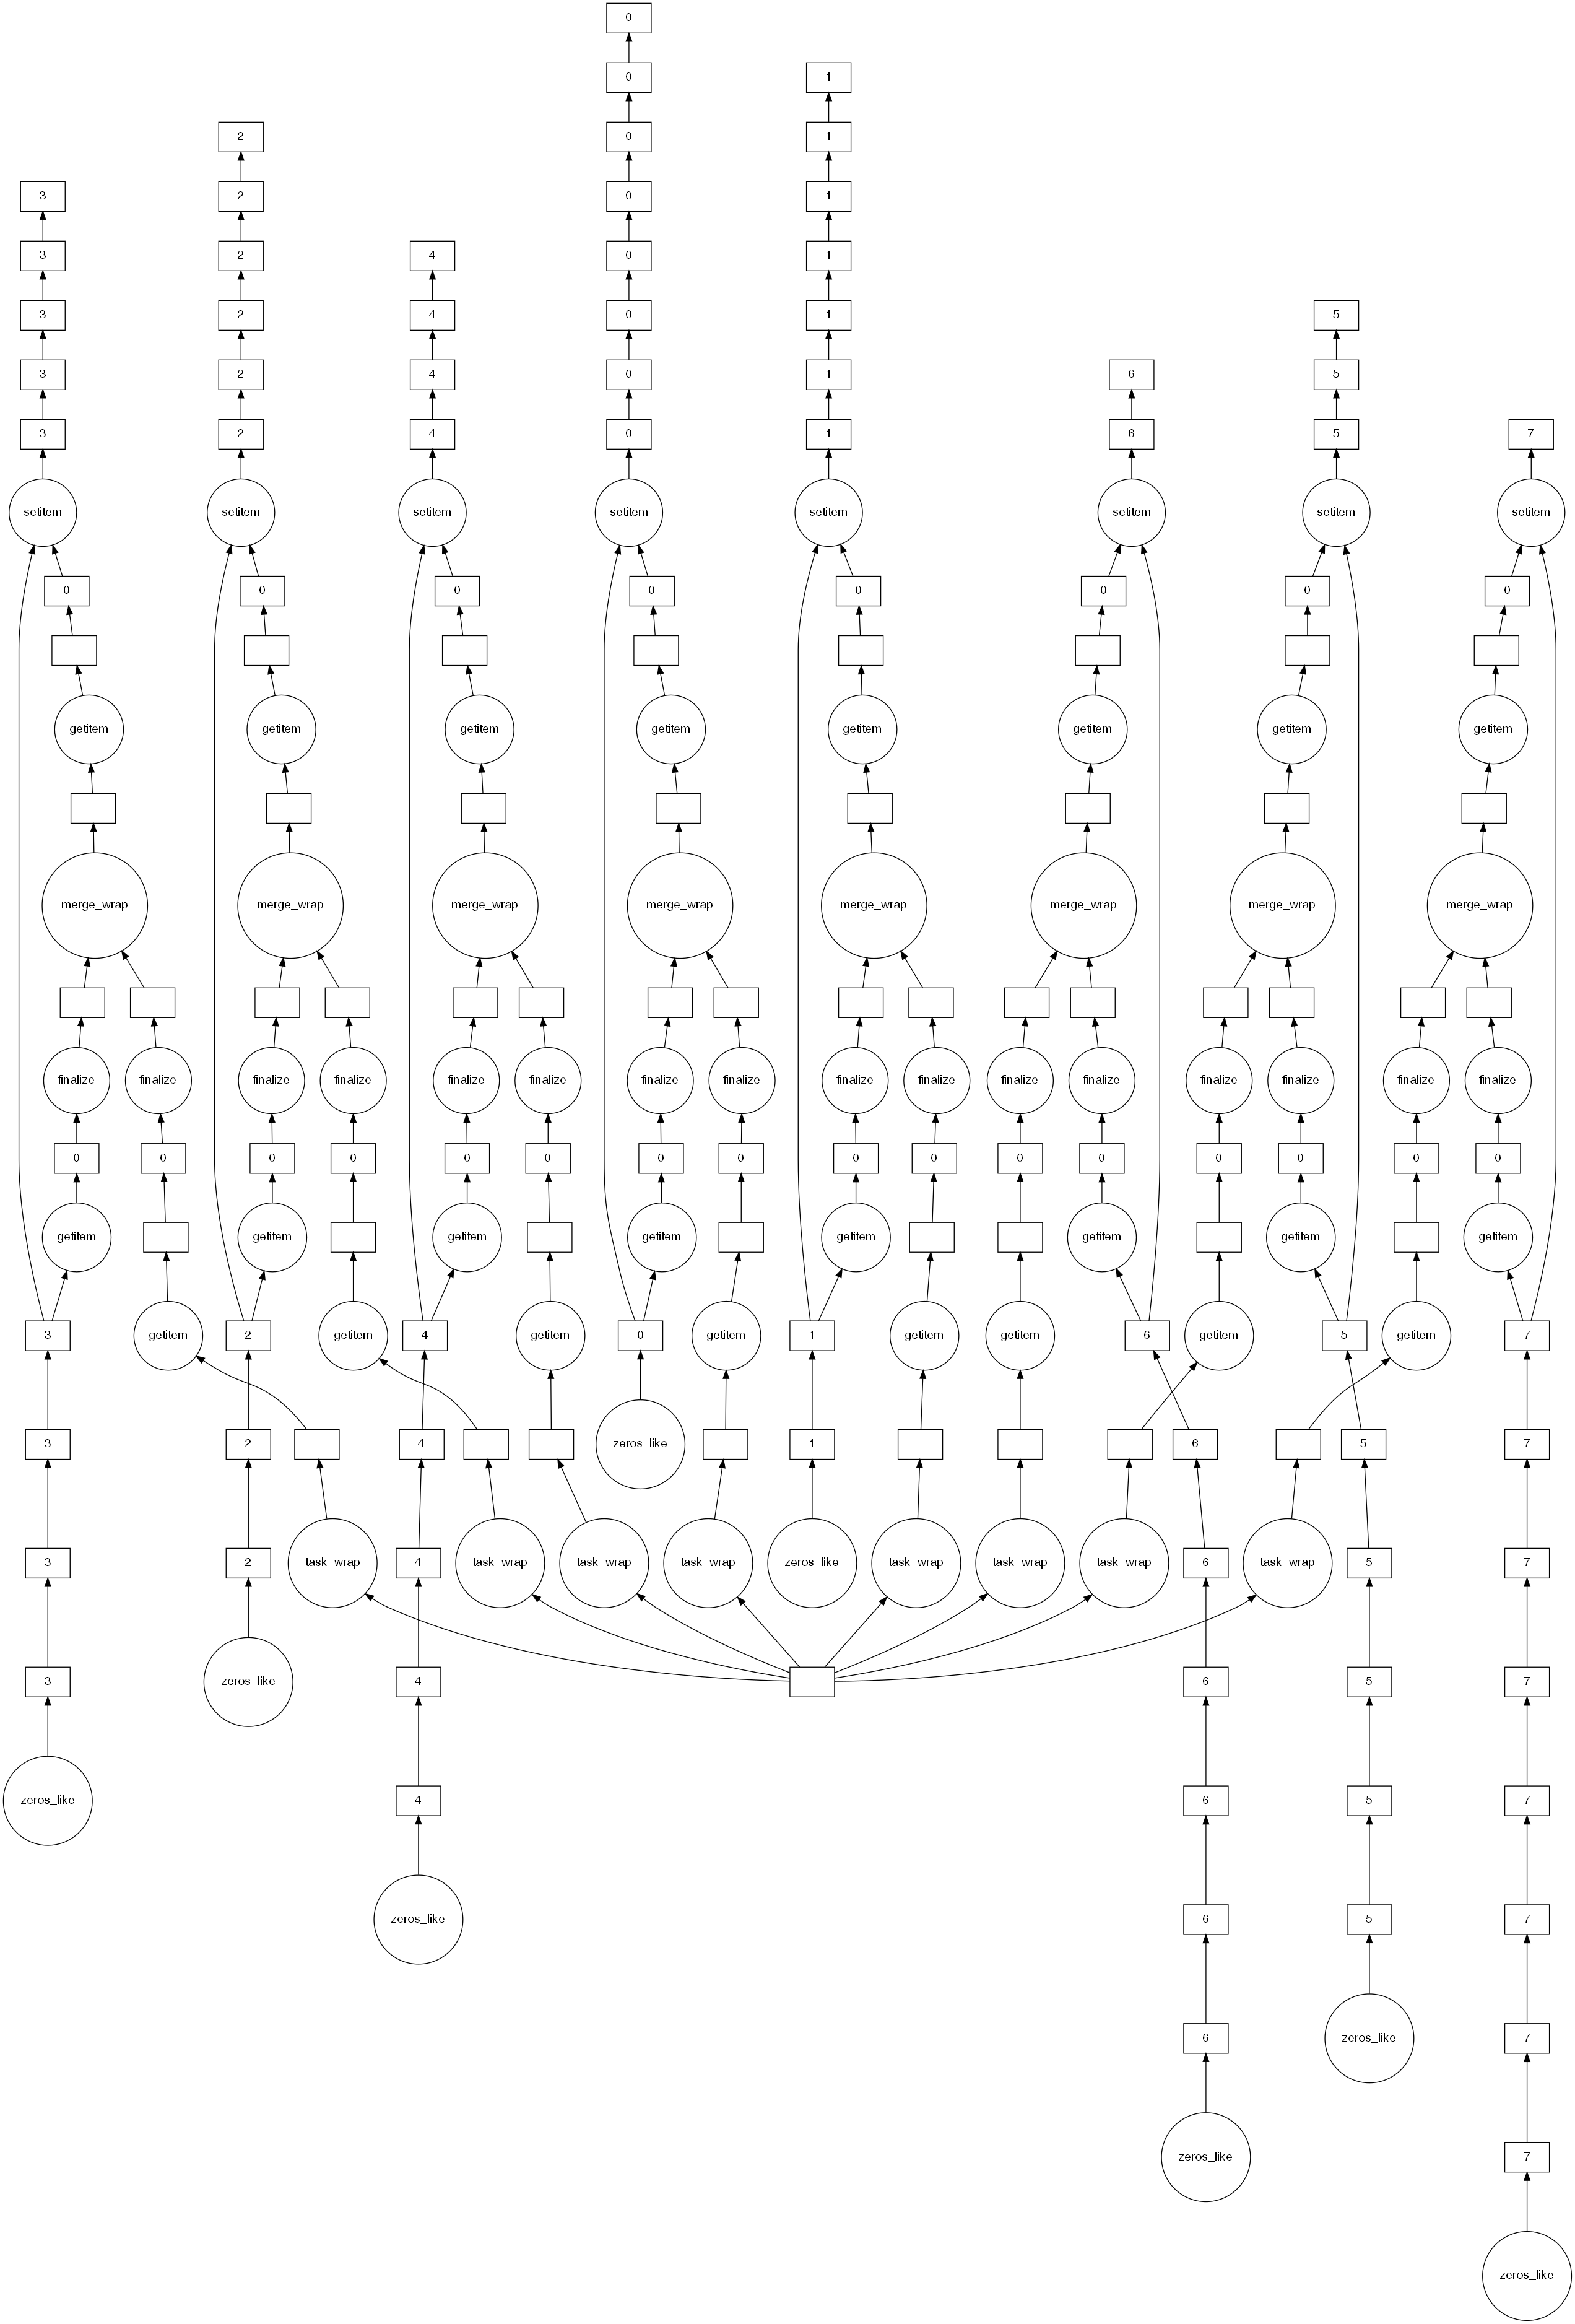

In [32]:
udf = MySumSigUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.visualize()


In [14]:
class MyMySumSigMergeUDF(MySumSigUDF):
    def dask_merge(self, ordered_results):
        intensity = np.concatenate([b.intensity for b in ordered_results.values()])
        self.results.get_buffer('intensity').update_data(intensity)

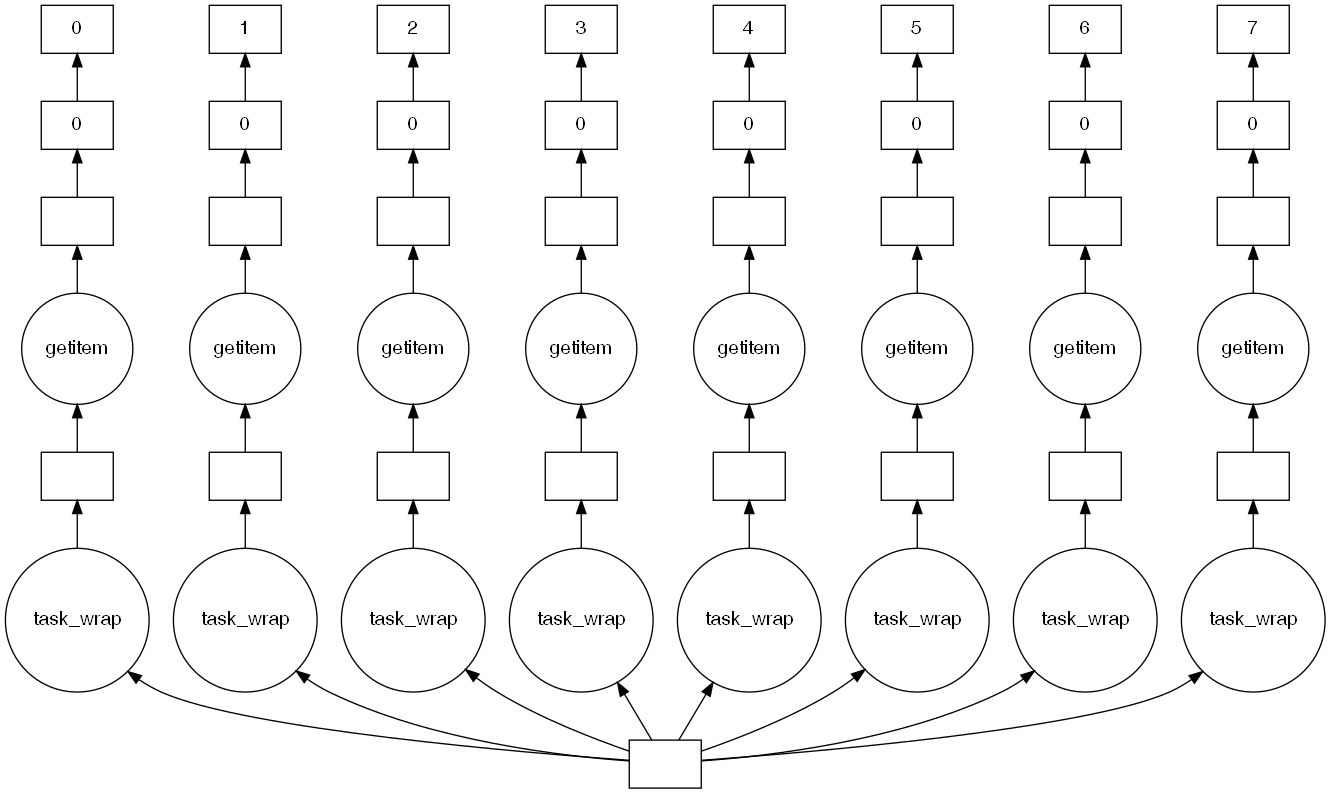

In [33]:
udf = MyMySumSigMergeUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.visualize()

In [15]:
%%timeit
udf = MyMySumSigMergeUDF()
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)
del_res_sumsig['intensity'].raw_data.compute()

2.48 s ± 392 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
udf = MyMySumSigMergeUDF()
resources = DelayedJobExecutor.get_resources(udf)
del_res_sumsig = del_ctx.run_udf(dataset=ds, udf=udf)

In [17]:
udf = MySumSigUDF()
resources = DelayedJobExecutor.get_resources(udf)
del_res_sumsig_merge = del_ctx.run_udf(dataset=ds, udf=udf)

In [18]:
dask.compute(del_res_sumsig, del_res_sumsig_merge)

({'intensity': <DaskBufferWrapper kind=nav extra_shape=() backing=dask.array<concatenate, shape=(65536,), dtype=float32, chunksize=(8192,), chunktype=numpy.ndarray>>},
 {'intensity': <DaskBufferWrapper kind=nav extra_shape=() backing=dask.array<setitem, shape=(65536,), dtype=float32, chunksize=(8192,), chunktype=numpy.ndarray>>})

In [23]:
128*128*256*256*4

4294967296